### In this project, I have trained Yolov3 on a collect fo 3000 gun images to detect hand gun. Since my computer doesn't have GPU, I decided to train the model on Google Colab. You can refer to how I train my model on Colab [here](./Colab_train_yolov3.ipynb).

In [89]:
import numpy as np
import time
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
# display function to show image on Jupyter
def display_img(img,cmap=None):
    fig = plt.figure(figsize = (12,12))
    plt.axis(False)
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)

#### Load YOLOv3 architecture and pre-trained weight

In [91]:
# Load the COCO class labels in which our YOLO model was trained on

labelsPath = os.path.join("yolo.names")
LABELS = open(labelsPath).read().strip().split("\n")

In [92]:
# The COCO dataset contains 80 different classes
LABELS

['gun']

In [108]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.join("yolov3_custom_train_900.weights")
configPath = os.path.join("yolov3_custom_test.cfg")

In [109]:
# Loading the neural network framework Darknet (YOLO was created based on this framework)
net = cv2.dnn.readNetFromDarknet(configPath,weightsPath)

In [113]:
# Create the function which predict the frame input
def predict(image):
    
    # initialize a list of colors to represent each possible class label
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")
    (H, W) = image.shape[:2]
    
    # determine only the "ouput" layers name which we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    
    # construct a blob from the input image and then perform a forward pass of the YOLO object detector, 
    # giving us our bounding boxes and associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)
    
    boxes = []
    confidences = []
    classIDs = []
    threshold = 0.2
    
    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            # confidence type=float, default=0.5
            if confidence > threshold:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, threshold, 0.1)

    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # draw a bounding box rectangle and label on the image
            color = (255,0,0)
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x +15, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                1, color, 2)
    return image

### Now let try to apply on images and a video

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


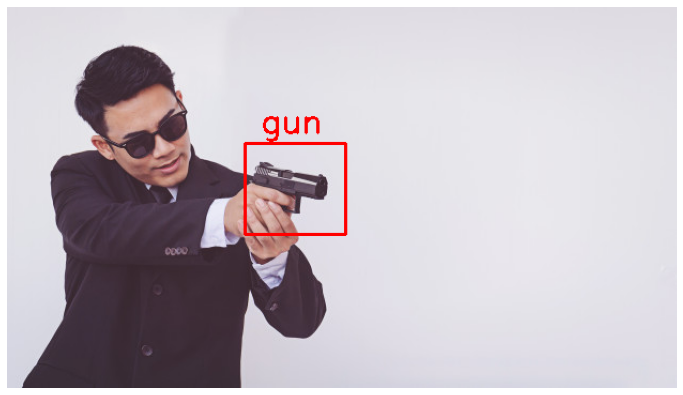

In [114]:
# Execute prediction on a single image
img = cv2.imread("pistol.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
display_img(predict(img))

In [29]:
### Apply Yolov3 for object dectection on a video

cap =cv2.VideoCapture('Roberry.mp4')

number_frame = 30.0 #higher frames better quality of the video
video_size = (1280,720)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('gun_detection.mp4',fourcc, number_frame,video_size)

while True:
    ret,frame = cap.read() 
    
    if ret:
        
        frame = cv2.resize(frame, (1280,720))
        frame = predict(frame)
        cv2.imshow("image",frame)
        out.write(frame)

        if cv2.waitKey(1) & 0xff == ord("q"):
            break
    else:
        break
        
cap.release()   
out.release()
cv2.destroyAllWindows()

#### Belows is an frame from the my processed video. 
![img](gun_detection.gif)

### Conclusion
- From the predict video, you can see that my model is confused between the gun and the barcode scanner. In addition, when the gun is moved in fast motion, the model lose track of it and in many frames can not detect the gun. I believe the reason is beacuse the limitation of dataset (3000 images are relative small data) and I can train only to 900 epochs (Colab broke after 900 epochs due to out of memory).